In [70]:
# imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from IPython.core.display import display, HTML, Markdown
from cpymad.madx import Madx
%matplotlib notebook

### Yann's example extracting a Matrix from MADX
https://gitlab.cern.ch/abt-optics-and-code-repository/simulation-codes/cpymad_examples/-/blob/master/MATRIX_extraction.ipynb

In [71]:
def get_matrix_from_twiss(twiss):
    elem = twiss.iloc[-1] # iloc[-1] takes last row of the data frame
    matExtracted = np.matrix([
        elem[['re11', 're12', 're13', 're14', 're15', 're16']].values.astype(float),
        elem[['re21', 're22', 're23', 're24', 're25', 're26']].values.astype(float),
        elem[['re31', 're32', 're33', 're34', 're35', 're36']].values.astype(float),
        elem[['re41', 're42', 're43', 're44', 're45', 're46']].values.astype(float),
        elem[['re51', 're52', 're53', 're54', 're55', 're56']].values.astype(float),
        elem[['re61', 're62', 're63', 're64', 're65', 're66']].values.astype(float),
    ])
    return matExtracted

### This is a test to run the whole get_initial_conditions_lhc_q20.madx file

In [72]:
## madx = Madx(command_log="commandlog") #Writes the errors in this file once madx has quit
## madx.option(verbose=False, debug=False, echo=True, warn=False, twiss_print=False) #Hides the output in the terminal
## madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls/ps_extraction/tt2tt10_lhc_q20/stitched/get_initial_conditions_lhc_q20.madx")
## madx.quit()

## D16STRAY and F16SHIM are the two elements to consider fringe fields in MU16

#### we place them as seen in: https://gitlab.cern.ch/acc-models/acc-models-tls/-/blob/2021/ps_extraction/tt2tt10_lhc_q20/stitched/get_initial_conditions_lhc_q20.madx

In [73]:
madx = Madx(command_log="commandlog") #Writes the errors in this file once madx has quit
madx.option(verbose=False, debug=False, echo=True, warn=False, twiss_print=False)

madx.beam(particle='proton', pc=26, exn=3.5e-6,eyn=3.5E-6)
madx.input('BRHO:= BEAM->PC * 3.3356;')

#len_ft16 = 7.701173928

# madx.command.sequence.clone('S1', refer=entry, l=len_ft16)
madx.input('FT16: sequence, refer=entry, l=7.701173928;')
madx.command.endsequence()

madx.command.rbend.clone('D16STRAY', L=2.20480, ANGLE=0.0, K1=-.047, K2=0.33)
madx.command.rbend.clone('F16SHIM', L=2.19624,ANGLE=0.021,K1=0.0)

madx.command.seqedit(sequence='FT16')
madx.command.install(element='D16STRAY_1', class_='D16STRAY', at='2.700072902') # Random positions, remeber starts from middle
madx.command.install(element='F16SHIM_1', class_='F16SHIM', at='4.904893572')
madx.command.endedit()

madx.use(sequence="FT16")


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.07.21 16:54:56      +
  ++++++++++++++++++++++++++++++++++++++++++++


#### Here I used the Initial conditions from MADX stitched model of PS extraction to TT10 LHC Q20 beam

- betx0              =       2.5103613982e+01 ;
- bety0              =       8.3789531557e+00 ;
- alfx0              =      -2.3322645191e+00 ;
- alfy0              =       9.7954156718e-01 ;
- dx0                =       3.0982680415e+00 ;
- dy0                =       0.0000000000e+00 ;
- dpx0               =       2.6262543044e-01 ;
- dpy0               =       0.0000000000e+00 ;

## Do i need to change the initial x here and look at the output x ?
### But then the transport matrix would be different depending on the input...

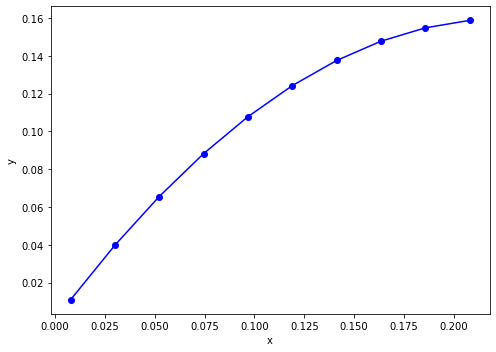

In [96]:
LHCx = 1.078422e-01
LHCxp = 3.131043e-02
TOFx = 1.173072e-01
TOFxp = 2.975372e-02
ADx = 1.101851e-01
ADxp = 2.973021e-02


values_lim = 0.1 # calculate the coefficient in the range +/-values_lim
values_no = 10;
xvalues = np.linspace(-values_lim, values_lim, values_no)+LHCx # This centers the linspace around the position of the beam
yvalues = np.zeros(values_no)
vectorOld = np.array([[0.], [0.], [0.], [0.], [0.], [0.]])

for i in range (0,values_no): 
    
    twiss = madx.twiss(betx=2.5103613982e+01, bety=8.3789531557e+00,
                       alfx=-2.3322645191e+00, alfy=9.7954156718e-01,
                       x=xvalues[i],
                       dx=3.0982680415e+00, dy=0.0000000000e+00,
                       dpx=2.6262543044e-01, dpy=0.0000000000e+00,
                       rmatrix=True).dframe()

    matExtracted = get_matrix_from_twiss(twiss)

    vectorOld[0]=xvalues[i]
    vectorNew = np.dot(matExtracted,vectorOld) # Matrix multiplication    
    yvalues[i]=vectorNew[0]

fig, ax = plt.subplots(1, 1, figsize=(7,5), tight_layout=True, sharex=True)

ax.plot(xvalues, yvalues, marker = 'o', color = 'b')
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.show()

#### Let's extract the matrix from the twiss

In [75]:
matExtracted = get_matrix_from_twiss(twiss)
print ("Extracted matrix:\n\n",matExtracted)

Extracted matrix:

 [[ 1.41734032  9.23833294  0.          0.          0.          0.03568377]
 [ 0.10761688  1.40700192  0.          0.          0.          0.02101444]
 [ 0.          0.          0.60877243  6.2475826   0.          0.        ]
 [ 0.          0.         -0.09988076  0.6176145   0.          0.        ]
 [-0.02594444 -0.14393128  0.          0.          1.          0.0098676 ]
 [ 0.          0.          0.          0.          0.          1.        ]]


## Plot one matrix coefficient of the extracted matrix to test

- I'm varying one parameter at a time (x, xp, y, yp, T, PT) with the other coordinates set to zero such as:

\begin{equation}
\left(\begin{array}{c}
{\pmb{x^{New}}}  \\
{x'^{New}}  \\
{y^{New}}  \\
{y'^{New}}  \\
{t^{New}}  \\
{(\frac{\delta p}{p})^{New}}  \\
\end{array}\right) =
\left(\begin{array}{cccccc}
R_{11} & R_{12} & R_{13} & R_{14} & R_{15} & R_{16} \\
R_{21} & R_{22} & R_{23} & R_{24} & R_{25} & R_{26} \\
R_{31} & R_{32} & R_{33} & R_{34} & R_{35} & R_{36} \\
R_{41}  & R_{42} & R_{43} & R_{44} & R_{45} & R_{46} \\
R_{51} & R_{52} & R_{53} & R_{54} & R_{55} & R_{56} \\
R_{61} & R_{62} & R_{63} & R_{64} & R_{65} & R_{66} \\
\end{array}\right)
\left(\begin{array}{c}
{\pmb{x^{Old}}}  \\
{0}  \\
{0}  \\
{0}  \\
{0}  \\
{0}  \\
\end{array}\right)
\end{equation}


 with $x^{Old}$ = [-0.01  -0.005  0.     0.005  0.01 ] for example
- I plot $x^{New}$ as a function of $x^{Old}$
- then $x^{New}$ as a function of $x'^{Old}$
- ...
- $(\frac{\delta p}{p})^{New}$ as a function of $(\frac{\delta p}{p})^{Old}$

### I'm also starting from different position depending on the beam type

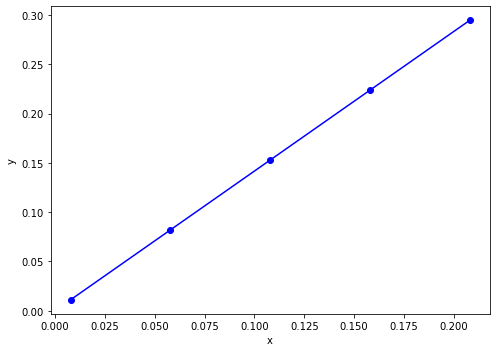

In [76]:
if True: # Necessary otherwise you get an output in the console
    LHCx = 1.078422e-01
    values_lim = 0.1 # calculate the coefficient in the range +/-values_lim
    values_no = 5      # choose how many points you want to calculate
    xvalues = np.linspace(-values_lim, values_lim, values_no)+LHCx # This centers the linspace around the position of the beam
    yvalues = np.zeros(values_no)
    vectorOld = np.array([[0.], [0.], [0.], [0.], [0.], [0.]])
        
    for i in range (0,values_no):        
        vectorOld[0]=xvalues[i]
        vectorNew = np.dot(matExtracted,vectorOld) # Matrix multiplication    
        yvalues[i]=vectorNew[0]

    fig, ax = plt.subplots(1, 1, figsize=(7,5), tight_layout=True, sharex=True)
    
    ax.plot(xvalues, yvalues, marker = 'o', color = 'b')
    ax.set_xlabel("x")
    ax.set_ylabel("y")